<h1>Яндекс музыка. Обнаружение каверов музыкальных треков<span class="tocSkip"></span></h1>

**Бизнес-задача:** Обнаружение каверов-треков — продуктовая задача, которая может 
улучшить качество рекомендаций стримингового сервиса. Если мы умеем с высокой 
точностью и скоростью классифицировать треки как каверы и связывать их между собой, 
то можно предложить пользователю новые возможности для управления Моей волной. 
Например:
 - По желанию пользователя полностью исключить каверы из Моей волны или наоборот 
оставить в рекомендациях только каверы;
- Предложить все каверы для любимого трека пользователя;
- Сбалансировать долю каверов в Моей волне для пользователя.

**ML-задача:** Необходимо разработать ML-продукт, который:
- находит все кавер-треки и/или исходники к заданному треку в датасете;
- перечисляет все кавер-треки и/или оригиналы к заданному, указывает положение данного трека в цепочке каверов.

Для упрощения разделим задачу на две: классификация трека кавер/оригинал и поиск похожих треков по заданному.

<h2>Исходные данные<span class="tocSkip"></span></h2>

Файл **covers.json** содержит разметку каверов, сделанную редакторами сервиса:
- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

💡 Известно, что не для всех каверов указаны идентификаторы исходных треков.

Файл **meta.json** содержит метаниформацию:
- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

Файл **lyrics.json** содержит тексты песен:
- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

## Разведывательный анализ данных

### Импорт данных

Импортируем необходимые для работы библиотеки. Считаем данные из json-файлов в датафреймы, сохраним в переменные и выведем на экран каждую таблицу.

In [1]:
# data analysis
import pandas as pd
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors


from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
)
from category_encoders import MEstimateEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    RandomizedSearchCV,
    cross_val_score,
    KFold
)

from sklearn.metrics import (
    f1_score,
    roc_curve,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# NLP
import re
from lingua import (
    Language,
    LanguageDetectorBuilder
)

# misc
from ydata_profiling import ProfileReport
import datetime
from collections import Counter
import warnings

In [2]:
try:
    covers_df = pd.read_json('covers.json', lines=True)
    lyrics_df = pd.read_json('lyrics.json', lines=True)
    meta_df = pd.read_json('meta.json', lines=True)
except:
    print('Данные не найдены')

# отображение всех столбцов таблицы
pd.set_option('display.max_columns', None)

# убираем предупреждение sklearn об отсутствии имен признаков
warnings.filterwarnings('ignore')

In [3]:
'''
Функция выводит 5 первых и последних
записей датасета
'''
def disp(data, info=False):
    print(data.shape)
    if info:
        print(data.info())
    return pd.concat([data.head(), data.tail()])

In [4]:
disp(covers_df, True)

(71597, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB
None


,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER
71592,4788e0bf61d80ef5ec9380aa8a8119d9,4788e0bf61d80ef5ec9380aa8a8119d9,ORIGINAL
71593,None,78b2db35476f134dc3cdfbf4d77ba034,COVER
71594,None,e720ff378efe032df56e0e656a6a92d3,COVER
71595,554e33d79e258da91149c3a4985cf6a1,554e33d79e258da91149c3a4985cf6a1,ORIGINAL
71596,7b0f6ff24137be50cf5ea5f82d789448,7b0f6ff24137be50cf5ea5f82d789448,ORIGINAL


In [5]:
disp(meta_df, True)

(71769, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB
None


,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0
71764,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,[INDIE],212690.0
71765,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,[POP],237540.0
71766,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,[ALTERNATIVE],215210.0
71767,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,[ALTERNATIVE],251010.0
71768,5731fc0a34c663a0c0082c712df15266,1.625087e+12,17,RU,FR59R1921791,"[POP, RUSPOP]",175640.0


In [6]:
disp(lyrics_df, True)

(11414, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB
None


,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659
11409,90522f12df92da5d585f8f6ec9bb34b5,All my little plans and schemes\nLost like som...,b734225e54122798535b40666e6e361e
11410,b82bd468c888ae17d2e976c8cf3b9d4c,I will make my way\nI'm trying to survive anot...,b3cbb82e4ef67e75b1e47054a681db86
11411,22bae9d3185254ea34072c692a2cd63d,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d
11412,0979b4049635e1c0fc161573f75ab23a,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d
11413,4c07f8d17222f821114790241f816431,Этой ночью чьё-то сердце от любви горит\nВсё в...,c860754a50dac664d847bca85e6897f4


**Промежуточный вывод:** данные подгрузились нормально, можно заметить, что текстов песен намного меньше, чем записей с метаинформацией. В признаке `language` много пропущенных значений, `duration` скорее всего представлен в миллисекундах, `dttm` – дата, записанная в формате unix.  

### Обработка данных

Объединим таблицы `meta_df` и `covers_df`. Так как выборка с текстами предоставлена в урезанном варианте, не будем её использовать в данном анализе. Выведем графики для количественных признаков и отчет.

In [7]:
full_df = pd.merge(
    left=meta_df,
    right=covers_df,
    left_on='track_id',
    right_on='track_id',
    how='inner')
disp(full_df)

(71597, 9)


,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0,None,COVER
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0,None,COVER
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0,None,COVER
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0,None,COVER
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0,None,COVER
71592,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,[INDIE],212690.0,None,COVER
71593,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,[POP],237540.0,None,COVER
71594,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,[ALTERNATIVE],215210.0,None,COVER
71595,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,[ALTERNATIVE],251010.0,None,COVER
71596,5731fc0a34c663a0c0082c712df15266,1.625087e+12,17,RU,FR59R1921791,"[POP, RUSPOP]",175640.0,5731fc0a34c663a0c0082c712df15266,ORIGINAL


In [8]:
# переведем миллисекунды в секунды
full_df['duration'] = full_df['duration'] / 1000

# перевод даты в человеческий формат
full_df['date'] = full_df['dttm'].apply(
    lambda x: 
    datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S'))

full_df['date'] = pd.to_datetime(full_df['date'])

# жанры записаны в виде списков, переведем их в string
full_df['genres'] = full_df['genres'].apply(lambda x: ' '.join(x))
full_df['genres'] = full_df['genres'].str.lower()

# замена классов на 0 и 1
full_df.loc[
    full_df['track_remake_type'] == "COVER", 'track_remake_type'] = 0
full_df.loc[
    full_df['track_remake_type'] == "ORIGINAL", 'track_remake_type'] = 1

# заполнение длительности медианой
full_df.loc[
    full_df['duration'] == 0, 'duration'] = full_df['duration'].median()

In [9]:
# проверка на явные дубликаты
full_df.duplicated().sum()

0

In [10]:
# создание репорта с описанием
full_profile = ProfileReport(full_df, title="Full Report", explorative=True)
full_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Промежуточный вывод:** в классах наблюдается высокий дисбаланс. Самая ранняя дата у трека – 2009 год, самая поздняя – 2023 год. Есть нулевые длины треков, их немного, также есть и очень длинные треки, но большинство имеет длительность порядка трёх минут. Уникальных жанров 229 штук, уникальных языков 85. Есть пропуски в признаках `language` и `isrc`.

### Жанры

Жанров слишком много – выделим основные. Для совсем экзотических жанров, а также для пропущенных данных, создан специальный жанр `other`. 

In [11]:
# создаем признаки основных жанров и заполняем их нулями
full_df['pop'] = 0
full_df['blues'] = 0
full_df['rap'] = 0
full_df['folk'] = 0
full_df['rock'] = 0
full_df['soundtrack'] = 0
full_df['instrumental'] = 0
full_df['electronics'] = 0
full_df['other'] = 0

In [12]:
# раскидываем поджанры по основным жанрам
full_df.loc[full_df['genres'].str.contains(r'pop|estrada|dance'), 'pop'] = 1
full_df.loc[full_df['genres'].str.contains(r'rap'), 'rap'] = 1
full_df.loc[full_df['genres'].str.contains(r'soul|jazz|rnb|reg|blues'), 'blues'] = 1
full_df.loc[full_df['genres'].str.contains(r'folk|country'), 'folk'] = 1
full_df.loc[full_df['genres'].str.contains(r'metal|rock|altern|punk'), 'rock'] = 1
full_df.loc[full_df['genres'].str.contains(r'soundtrack'), 'soundtrack'] = 1
full_df.loc[full_df['genres'].str.contains(r'classical'), 'instrumental'] = 1
full_df.loc[full_df['genres'].str.contains(r'electronic|dance'), 'electronics'] = 1

full_df.loc[full_df['genres'].str.contains(r'pop|estrada|dance'), 'genres'] = 'Del'
full_df.loc[full_df['genres'].str.contains(r'rap'), 'genres'] = 'Del'
full_df.loc[full_df['genres'].str.contains(r'soul|jazz|rnb|regg|blues'), 'genres'] = 'Del'
full_df.loc[full_df['genres'].str.contains(r'folk|country'), 'genres'] ='Del'
full_df.loc[full_df['genres'].str.contains(r'metal|rock|altern|punk'), 'genres'] = 'Del'
full_df.loc[full_df['genres'].str.contains(r'soundtrack'), 'genres'] = 'Del'
full_df.loc[full_df['genres'].str.contains(r'classical'), 'genres'] = 'Del'
full_df.loc[full_df['genres'].str.contains(r'electronic|dance'), 'genres'] = 'Del'

# создание списка оставшихся поджанров, которые никуда не вошли
u_idx = list(full_df['genres'].unique())
u_idx.remove('Del')

# сохранение индексов объектов с оставшимися жанрами
u_idx = full_df.query('genres in @u_idx').index

# заполнение жанра other
full_df.loc[u_idx, 'other'] = 1
full_df.loc[u_idx, 'genres'] = 'Del'

In [13]:
# проверка, что все жанры обработаны
full_df['genres'].unique()

array(['Del'], dtype=object)

### ISRC

Код ISRC всегда состоит из 12 символов и записывается в формате «CC-XXX-YY-NNNNN» (дефисы не являются частью кода ISRC, но этот код часто пишут таким образом, чтобы облегчить его чтение). Упомянутые выше четыре части означают:

- «CC» означает код страны согласно ISO 3166-1 alpha-2;
- «XXX» — трёхзначный алфавитно-цифровой регистрационный код, уникальным образом определяющий организацию, которая регистрирует код. Например, в Великобритании это Phonographic Performance Limited (PPL);
- «YY» — последние две цифры года регистрации (не обязательно соответствуют году, когда произведена запись);
- «NNNNN» — уникальная последовательность из пяти цифр, определяющая определённую аудиозапись.

В ISRC есть пропуски. Будем считать, что это треки, еще не получившие номер, заполним их форматом `XXXXX23XXXXX`. Также сгенерим новые признаки из номера ISRC – код страны, организацию и год выдачи номера.

In [14]:
# функция, которая оставляет только латинские символы и цифры
def isrc(text):
    return re.sub(r'[^a-z, ^A-Z, ^0-9 ]', '', text)

# заполнение пропусков и очистка isrc от лиших символов
full_df['isrc'].fillna('XXXXX23XXXXX', inplace=True)
full_df['isrc'] = full_df['isrc'].apply(lambda x: isrc(x))

In [15]:
# генерация новых признаков
full_df['country'] = full_df['isrc'].apply(lambda x: x[:2])
full_df['organization'] = full_df['isrc'].apply(lambda x: x[2:5])
full_df['year'] = full_df['isrc'].apply(lambda x: x[5:7])

In [16]:
# объедиенение кодов для стран с несколькими кодами
full_df.loc[full_df['country'].str.contains(r'QZ|QM'), 'country'] = 'US'
full_df.loc[full_df['country'].str.contains(r'GB|GX'), 'country'] = 'UK'
full_df.loc[full_df['country'].str.contains(r'BC|BX|BK|BP'), 'country'] = 'BR'
full_df.loc[full_df['country'].str.contains(r'GL|FO'), 'country'] = 'DK'
full_df.loc[full_df['country'].str.contains(r'KS'), 'country'] = 'KR'

full_df['country'] = full_df['country'].str.lower()

Так как год получен в формате последних двух цифр, сконвертируем его в unix time.

In [17]:
full_df['year'].unique()

array(['21', '18', '20', '22', '19', '99', '01', '00', '17', '16', '14',
       '12', '08', '05', '23', '15', '09', '82', '30', '33', '77', '36',
       '35', '50', '62', '04', '70', '66', '06', '10', '96', '95', '07',
       '11', '03', '13', '02', '24', '81', '73', '60', '71', '38', '85',
       '98', '63', '90', '94', '87', '80', '78', '84', '88', '76', '74',
       '79', '92', '89', '91', '86', '97', '83', '93', '51', '25', '42',
       '26', '69', '68', '67', '75', '65', '58', '54', '57', '44', '64'],
      dtype=object)

In [18]:
# функция для обработки года
def years(x):
    if x > 23:
        return 1900 + x
    else:
        return 2000 + x

    
full_df['year'] = full_df['year'].apply(lambda x: years(int(x)))
full_df['year'] = pd.to_datetime(full_df['year'], format='%Y')
full_df['unix'] = full_df['year'].apply(lambda x: x.timestamp() * 1000)

disp(full_df)

(71597, 23)


,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,date,pop,blues,rap,folk,rock,soundtrack,instrumental,electronics,other,country,organization,year,unix
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,Del,161.12,None,0,2021-12-16 21:00:00,1,0,0,0,0,0,0,1,0,ru,B42,2021-01-01,1.609459e+12
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,Del,362.26,None,0,2021-11-24 14:00:33,0,0,0,0,0,0,0,1,0,us,N88,2021-01-01,1.609459e+12
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,Del,260.00,None,0,2021-11-24 15:37:03,0,0,0,1,0,0,0,0,0,us,NJZ,2021-01-01,1.609459e+12
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,Del,190.00,None,0,2021-11-24 15:37:03,0,0,0,1,0,0,0,0,0,us,NJZ,2021-01-01,1.609459e+12
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,Del,203.00,None,0,2021-11-24 15:37:03,0,0,0,1,0,0,0,0,0,us,NJZ,2021-01-01,1.609459e+12
71592,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,FR,CAISO1800023,Del,212.69,None,0,2019-06-13 05:20:09,0,0,0,0,0,0,0,0,1,ca,ISO,2018-01-01,1.514765e+12
71593,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,None,ES71G1738868,Del,237.54,None,0,2019-06-13 13:34:03,1,0,0,0,0,0,0,0,0,es,71G,2017-01-01,1.483229e+12
71594,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,EN,USA2B1511447,Del,215.21,None,0,2019-06-13 17:50:02,0,0,0,0,1,0,0,0,0,us,A2B,2015-01-01,1.420070e+12
71595,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,EN,USA2B1511448,Del,251.01,None,0,2019-06-13 17:50:02,0,0,0,0,1,0,0,0,0,us,A2B,2015-01-01,1.420070e+12
71596,5731fc0a34c663a0c0082c712df15266,1.625087e+12,17,RU,FR59R1921791,Del,175.64,5731fc0a34c663a0c0082c712df15266,1,2021-06-30 21:00:00,1,0,0,0,0,0,0,0,0,fr,59R,2019-01-01,1.546301e+12


### Язык

В признаке `language` много пропусков, но это потенциально полезный признак, поэтому попробуем заполнить его с помощью названий песен. Для этого используем библиотеку lingua. Для обработки языков выберем топ уже встречавшихся в датасете языков. Также добавим португальский для уменьшения количества ошибок библиотеки распознавания. В дальнейшем, заменим португальский на испанский. 

In [19]:
# инициализация используемых языков
languages = [
    Language.ENGLISH,
    Language.FRENCH,
    Language.GERMAN,
    Language.SPANISH,
    Language.RUSSIAN,
    Language.ITALIAN,
    Language.HINDI,
    Language.PORTUGUESE]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

In [20]:
# заполняем пропуски в языке кодами стран isrc у треков с численными названиями
idx = full_df[full_df['title'].str.isnumeric() & (full_df['language'].isna())].index
full_df.loc[idx, 'language'] = full_df.loc[idx, 'country']

# заполняем пропуски в языке кодами стран isrc у треков с коротким названием
idx = full_df[(full_df['title'].str.len() < 2) & (full_df['language'].isna())].index
full_df.loc[idx, 'language'] = full_df.loc[idx, 'country']

In [21]:
# заполнение столбца temp распознанными языками
full_df['temp'] = ''
full_df.loc[
    full_df['language'].isna(), 'temp'] = \
    full_df.loc[
    full_df['language'].isna(), 'title'].apply(lambda x: detector.detect_language_of(x))

In [22]:
# заполнение пропусков в language значениями из temp
full_df.loc[
    full_df['language'].isna() & ~full_df['temp'].isna(), 'language'] = \
    full_df.loc[full_df['language'].isna() & ~full_df['temp'].isna(), 'temp'].apply(lambda x: x.name)

In [23]:
# заполняем оставшиеся пропуски в языке кодами стран isrc
full_df.loc[full_df['language'].isna(), 'language'] = \
            full_df.loc[full_df['language'].isna(), 'country']

In [24]:
# приведение языков к единому виду
full_df['language'] = full_df['language'].str.lower()

full_df.loc[full_df['language'].str.contains(r'spa'), 'language'] = 'es'
full_df.loc[full_df['language'].str.contains(r'rus'), 'language'] = 'ru'
full_df.loc[full_df['language'].str.contains(r'ita'), 'language'] = 'it'
full_df.loc[full_df['language'].str.contains(r'por'), 'language'] = 'es'
full_df.loc[full_df['language'].str.contains(r'ger'), 'language'] = 'de'
full_df.loc[full_df['language'].str.contains(r'hin'), 'language'] = 'hi'
full_df.loc[full_df['language'].str.contains(r'fre'), 'language'] = 'fr'
full_df.loc[full_df['language'].str.contains(r'eng|us|uk'), 'language'] = 'en'

In [25]:
# топ-10 языков
full_df['language'].value_counts().head(10)

language
en    33371
es    25968
it     3481
ru     3404
fr     1693
de     1682
hi      285
zh      212
ja      174
th      162
Name: count, dtype: int64

In [26]:
# выберем топ-6 языков и оставим только их
langs = list(full_df['language'].value_counts().head(6).index)
langs

['en', 'es', 'it', 'ru', 'fr', 'de']

In [27]:
full_df = full_df.query('language in @langs')
disp(full_df)

(69599, 24)


,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,date,pop,blues,rap,folk,rock,soundtrack,instrumental,electronics,other,country,organization,year,unix,temp
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,en,RUB422103970,Del,161.12,None,0,2021-12-16 21:00:00,1,0,0,0,0,0,0,1,0,ru,B42,2021-01-01,1.609459e+12,
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,en,QZN882178276,Del,362.26,None,0,2021-11-24 14:00:33,0,0,0,0,0,0,0,1,0,us,N88,2021-01-01,1.609459e+12,
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,es,QZNJZ2122549,Del,260.00,None,0,2021-11-24 15:37:03,0,0,0,1,0,0,0,0,0,us,NJZ,2021-01-01,1.609459e+12,Language.SPANISH
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,es,QZNJZ2166033,Del,190.00,None,0,2021-11-24 15:37:03,0,0,0,1,0,0,0,0,0,us,NJZ,2021-01-01,1.609459e+12,Language.SPANISH
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,es,QZNJZ2122551,Del,203.00,None,0,2021-11-24 15:37:03,0,0,0,1,0,0,0,0,0,us,NJZ,2021-01-01,1.609459e+12,Language.SPANISH
71592,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,Chanceuse,fr,CAISO1800023,Del,212.69,None,0,2019-06-13 05:20:09,0,0,0,0,0,0,0,0,1,ca,ISO,2018-01-01,1.514765e+12,
71593,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,Quiero Que Vuelvas,es,ES71G1738868,Del,237.54,None,0,2019-06-13 13:34:03,1,0,0,0,0,0,0,0,0,es,71G,2017-01-01,1.483229e+12,Language.SPANISH
71594,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,Vacation,en,USA2B1511447,Del,215.21,None,0,2019-06-13 17:50:02,0,0,0,0,1,0,0,0,0,us,A2B,2015-01-01,1.420070e+12,
71595,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,Dance Hall Days,en,USA2B1511448,Del,251.01,None,0,2019-06-13 17:50:02,0,0,0,0,1,0,0,0,0,us,A2B,2015-01-01,1.420070e+12,
71596,5731fc0a34c663a0c0082c712df15266,1.625087e+12,17,ru,FR59R1921791,Del,175.64,5731fc0a34c663a0c0082c712df15266,1,2021-06-30 21:00:00,1,0,0,0,0,0,0,0,0,fr,59R,2019-01-01,1.546301e+12,


### Название трека

Векторизуем названия треков. Так как названия, в отличие от текстов, содержат небольшое количество слов, используем подход "bag of characters". Создадим матрицу вида символ - количество символов в названии.

In [28]:
# удаление лишних признаков
full_df.drop(['isrc',
     'genres',
     'year',
     'temp',
     'date'],
    axis=1, inplace=True
)

In [29]:
# создание дополнительного признака - длина названия
full_df['length'] = full_df['title'].str.len()
full_df['title'] = full_df['title'].str.lower()
disp(full_df)

(69599, 20)


,track_id,dttm,title,language,duration,original_track_id,track_remake_type,pop,blues,rap,folk,rock,soundtrack,instrumental,electronics,other,country,organization,unix,length
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,happy new year,en,161.12,None,0,1,0,0,0,0,0,0,1,0,ru,B42,1.609459e+12,14
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,bad habits,en,362.26,None,0,0,0,0,0,0,0,0,1,0,us,N88,1.609459e+12,10
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,por esa loca vanidad,es,260.00,None,0,0,0,0,1,0,0,0,0,0,us,NJZ,1.609459e+12,20
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,mil lagrimas,es,190.00,None,0,0,0,0,1,0,0,0,0,0,us,NJZ,1.609459e+12,12
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,sexo humo y alcohol,es,203.00,None,0,0,0,0,1,0,0,0,0,0,us,NJZ,1.609459e+12,19
71592,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,chanceuse,fr,212.69,None,0,0,0,0,0,0,0,0,0,1,ca,ISO,1.514765e+12,9
71593,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,quiero que vuelvas,es,237.54,None,0,1,0,0,0,0,0,0,0,0,es,71G,1.483229e+12,18
71594,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,vacation,en,215.21,None,0,0,0,0,0,1,0,0,0,0,us,A2B,1.420070e+12,8
71595,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,dance hall days,en,251.01,None,0,0,0,0,0,1,0,0,0,0,us,A2B,1.420070e+12,15
71596,5731fc0a34c663a0c0082c712df15266,1.625087e+12,17,ru,175.64,5731fc0a34c663a0c0082c712df15266,1,1,0,0,0,0,0,0,0,0,fr,59R,1.546301e+12,2


In [30]:
# создание списка со всеми названиями треков и подсчет количества символов в датасете
un_list = full_df['title'].unique().tolist()
counts=Counter(''.join(un_list))
print(counts)

Counter({' ': 104173, 'e': 70247, 'a': 65907, 'o': 57560, 'r': 42843, 'i': 41479, 'n': 38260, 't': 36014, 's': 34035, 'l': 29881, 'm': 27559, 'd': 24968, 'u': 20953, 'c': 17963, 'h': 17387, 'g': 12427, 'p': 11983, 'f': 11013, 'b': 10197, 'y': 9732, 'v': 9569, 'w': 5865, 'k': 5385, '"': 4794, '(': 4227, ')': 4221, 'а': 2814, 'о': 2759, 'j': 2704, 'z': 2700, 'q': 2635, '/': 2559, "'": 2423, 'е': 2323, 'н': 1971, 'и': 1693, 'т': 1609, 'x': 1387, 'с': 1378, 'л': 1334, 'é': 1333, 'р': 1329, '-': 1260, 'ã': 1245, 'к': 1156, 'м': 1129, 'в': 1094, '.': 1093, 'д': 995, ',': 982, 'á': 937, 'ó': 902, 'у': 820, 'п': 810, 'я': 806, ':': 762, '2': 757, 'í': 695, 'б': 690, 'ç': 685, 'ê': 621, '0': 597, 'ы': 586, 'й': 548, 'ь': 539, '1': 501, 'з': 490, 'г': 471, 'ñ': 456, 'ч': 432, 'ú': 322, '3': 314, '4': 307, '!': 305, 'ш': 264, 'ю': 261, '&': 261, 'ж': 238, 'х': 215, 'ц': 211, '?': 195, '6': 184, '5': 163, '’': 162, '9': 160, 'ё': 159, '8': 157, 'ô': 155, '“': 142, '7': 122, '[': 104, ']': 104, 'ф'

В названиях треков остались символы других языков, но их немного, оставим всё как есть. Для создания векторов выберем топ-125 символов по частоте.

In [31]:
pd.Series(counts).sort_values(ascending=False).head(125)

     104173
e     70247
a     65907
o     57560
r     42843
      ...  
ن        14
%        14
ل        12
š        12
»        12
Length: 125, dtype: int64

In [32]:
# создание матрицы символов, заполненной нулями
cols = pd.Series(counts).sort_values(ascending=False).head(125).index
zero_feat = pd.DataFrame(0, columns=cols, index=full_df.index)
zero_feat

,,e,a,o,r,i,n,t,s,l,m,d,u,c,h,g,p,f,b,y,v,w,k,"""",(,),а,о,j,z,q,/,',е,н,и,т,x,с,л,é,р,-,ã,к,м,в,.,д,",",á,ó,у,п,я,:,2,í,б,ç,ê,0,ы,й,ь,1,з,г,ñ,ч,ú,3,4,!,ш,&,ю,ж,х,ц,?,6,5,’,9,ё,8,ô,“,7,[,],ф,à,”,э,è,õ,´,ü,щ,ä,#,¿,â,*,ò,і,+,ا,ي,~,ù,ı,ö,`,º,|,ì,ư,ن,%,ل,š,»
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71592,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71593,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71594,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71595,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
# объединим таблицы и заполним матрицу символом согласно названиям треков
full_df = pd.merge(left=full_df, right=zero_feat, left_index=True, right_index=True)

# функция заполняет соответствующий столбец в датасете количеством букв
def fill(row):
    counts = Counter(row['title'])
    for i in counts.keys():
        if i in full_df:
            full_df.loc[row.name, i] = counts[i]

full_df.apply(fill, axis=1)
disp(full_df)

(69599, 145)


,track_id,dttm,title,language,duration,original_track_id,track_remake_type,pop,blues,rap,folk,rock,soundtrack,instrumental,electronics,other,country,organization,unix,length,,e,a,o,r,i,n,t,s,l,m,d,u,c,h,g,p,f,b,y,v,w,k,"""",(,),а,о,j,z,q,/,',е,н,и,т,x,с,л,é,р,-,ã,к,м,в,.,д,",",á,ó,у,п,я,:,2,í,б,ç,ê,0,ы,й,ь,1,з,г,ñ,ч,ú,3,4,!,ш,&,ю,ж,х,ц,?,6,5,’,9,ё,8,ô,“,7,[,],ф,à,”,э,è,õ,´,ü,щ,ä,#,¿,â,*,ò,і,+,ا,ي,~,ù,ı,ö,`,º,|,ì,ư,ن,%,ل,š,»
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,happy new year,en,161.12,None,0,1,0,0,0,0,0,0,1,0,ru,B42,1.609459e+12,14,2,2,2,0,1,0,1,0,0,0,0,0,0,0,1,0,2,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,bad habits,en,362.26,None,0,0,0,0,0,0,0,0,1,0,us,N88,1.609459e+12,10,1,0,2,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,por esa loca vanidad,es,260.00,None,0,0,0,0,1,0,0,0,0,0,us,NJZ,1.609459e+12,20,3,1,4,2,1,1,1,0,1,1,0,2,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,mil lagrimas,es,190.00,None,0,0,0,0,1,0,0,0,0,0,us,NJZ,1.609459e+12,12,1,0,2,0,1,2,0,0,1,2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,sexo humo y alcohol,es,203.00,None,0,0,0,0,1,0,0,0,0,0,us,NJZ,1.609459e+12,19,3,1,1,4,0,0,0,0,1,2,1,0,1,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71592,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,chanceuse,fr,212.69,None,0,0,0,0,0,0,0,0,0,1,ca,ISO,1.514765e+12,9,0,2,1,0,0,0,1,0,1,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71593,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,quiero que vuelvas,es,237.54,None,0,1,0,0,0,0,0,0,0,0,es,71G,1.483229e+12,18,2,3,1,1,1,1,0,0,1,1,0,0,3,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71594,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,vacation,en,215.21,None,0,0,0,0,0,1,0,0,0,0,us,A2B,1.420070e+12,8,0,0,2,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71595,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,dance hall days,en,251.01,None,0,0,0,0,0,1,0,0,0,0,us,A2B,1.420070e+12,15,2,1,3,0,0,0,1,0,1,2,0,2,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71596,5731fc0a34c663a0c0082c712df15266,1.625087e+12,17,ru,175.64,5731fc0a34c663a0c0082c712df15266,1,1,0,0,0,0,0,0,0,0,fr,59R,1.546301e+12,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [34]:
'''
так как названия столбцов в виде символов json
не везде поддерживаются, переименуем символьные столбцы
'''
col_name = list(full_df.columns)
    
numbs = [str(i) for i in range(len(full_df.columns) - 19)]
full_df.columns = list(full_df.columns[:19]) + numbs
disp(full_df)

(69599, 145)


,track_id,dttm,title,language,duration,original_track_id,track_remake_type,pop,blues,rap,folk,rock,soundtrack,instrumental,electronics,other,country,organization,unix,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,happy new year,en,161.12,None,0,1,0,0,0,0,0,0,1,0,ru,B42,1.609459e+12,14,2,2,2,0,1,0,1,0,0,0,0,0,0,0,1,0,2,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,bad habits,en,362.26,None,0,0,0,0,0,0,0,0,1,0,us,N88,1.609459e+12,10,1,0,2,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,por esa loca vanidad,es,260.00,None,0,0,0,0,1,0,0,0,0,0,us,NJZ,1.609459e+12,20,3,1,4,2,1,1,1,0,1,1,0,2,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,mil lagrimas,es,190.00,None,0,0,0,0,1,0,0,0,0,0,us,NJZ,1.609459e+12,12,1,0,2,0,1,2,0,0,1,2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,sexo humo y alcohol,es,203.00,None,0,0,0,0,1,0,0,0,0,0,us,NJZ,1.609459e+12,19,3,1,1,4,0,0,0,0,1,2,1,0,1,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71592,4be93dea1715e54db86aaa7f7e9bfb10,1.560403e+12,chanceuse,fr,212.69,None,0,0,0,0,0,0,0,0,0,1,ca,ISO,1.514765e+12,9,0,2,1,0,0,0,1,0,1,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71593,7cba0f30eaa8766d6c203eff2f3750a2,1.560433e+12,quiero que vuelvas,es,237.54,None,0,1,0,0,0,0,0,0,0,0,es,71G,1.483229e+12,18,2,3,1,1,1,1,0,0,1,1,0,0,3,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71594,26b6aca1c6a02ad0e2a939164716657e,1.560448e+12,vacation,en,215.21,None,0,0,0,0,0,1,0,0,0,0,us,A2B,1.420070e+12,8,0,0,2,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71595,d904dda141238e6ad1b428bfbb21262d,1.560448e+12,dance hall days,en,251.01,None,0,0,0,0,0,1,0,0,0,0,us,A2B,1.420070e+12,15,2,1,3,0,0,0,1,0,1,2,0,2,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71596,5731fc0a34c663a0c0082c712df15266,1.625087e+12,17,ru,175.64,5731fc0a34c663a0c0082c

### Стандартизация признаков

Подготовим данные к обучению. Для этого создаим train и test выборки, инициализируем кодирование данных.

In [4]:
full_df = pd.read_csv('BACKUP_final.csv', index_col=0)

In [5]:
features = full_df.drop(['track_id',
                         'title',
                         'original_track_id',
                         'track_remake_type'],
                        axis=1
                       )

target = full_df['track_remake_type'].astype(int)

In [6]:
state = 42
# разбиваем данные на тренировочную, тестовую и валидационную выборки
# с соотношением 0.6 - 0.2 - 0.2
features_temp, features_test, target_temp, target_test = train_test_split(
    features, target, test_size=0.2, random_state=state, stratify=target)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_temp, target_temp, test_size=0.25, random_state=state, stratify=target_temp)

In [7]:
print('features',
      features_train.shape,
      features_valid.shape,
      features_test.shape,
      sep="\n")
print('target',
      target_train.shape,
      target_valid.shape,
      target_test.shape,
      sep="\n")

features
(41759, 141)
(13920, 141)
(13920, 141)
target
(41759,)
(13920,)
(13920,)


In [8]:
# категориальные и численные признаки
cat_f = ['language', 'country', 'organization']
numb_f = list(
    features_train.drop(['language', 'country', 'organization'], axis=1).columns)

transformer = make_column_transformer(
    (StandardScaler(), numb_f),
    (MEstimateEncoder(), cat_f))

## Машинное обучение

### Классификация оригинал/кавер

In [9]:
'''
Функция для подбора гиперпараметров.
Принимает модель, вид поиска, признаки,, гиперпараметры для перебора и название модели для отображения.
Строит пайплайн, запускает поиск гиперпараметров, выводит значения гиперпараметров и скор на обучении.
Возвращает лучший пайплайн и лучшую метрику.

search_type:
C - cross_val_score
G - GridSearchCV
R - RandomizedSearchCV
'''
def pipe(model,
         search_type,
         X_train, y_train,
         params,
         name,
         scoring='f1',
         cv=3):
    
     
    # ветка для cross_val_score
    if search_type == "C":      
        pipeline = make_pipeline(scaler, model)         
        model_score = cross_val_score(
            pipeline,
            X_train,
            y_train,
            scoring=scoring,
            cv=cv).mean()
        # значение скоринга на кросс-валидации
        print(f'best_score: {model_score.round(3)}'\
             f' для модели {name}')
        storage[name] = [model_score.round(3)]
    
        return pipeline
    
    # ветка для GridSearchCV
    elif search_type == "G":
        model.set_params(random_state=state)
        pipeline = make_pipeline(transformer, model)
        gs = GridSearchCV(
            pipeline, 
            param_grid=params, 
            scoring=scoring,
            n_jobs=-1,
            error_score='raise',
            verbose=2,
            cv=cv
        )        
        gs.fit(X_train, y_train)
        #лучшее значение скоринга на кросс-валидации
        print(f'best_score: {gs.best_score_.round(3)}'\
              f' для модели {name}')
        # лучшие гиперпараметры
        print(f'best_params: {gs.best_params_}')  
        storage[name] = [gs.best_score_.round(3)] 
        
        return gs.best_estimator_
    
    # ветка для RandomizedSearchCV
    elif search_type == "R":
        model.set_params(random_state=state)
        pipeline = make_pipeline(transformer, model)
        rs = RandomizedSearchCV(
            pipeline,
            param_distributions=params, 
            scoring=scoring,
            n_jobs=-1,
            random_state=state,
            verbose=2,
            cv=cv
        )
        rs.fit(X_train, y_train)
        # лучшее значение скоринга на кросс-валидации
        print(f'best_score: {rs.best_score_.round(3)}')
        # лучшие гиперпараметры
        print(f'best_params: {rs.best_params_}'\
              f' для модели {name}')
        storage[name] = [rs.best_score_.round(3)] 

        return rs.best_estimator_
        
    else: print('Введите верный search_type')   

#### Гиперпараметры

Проверим две модели с помощью кросс-валидации: логистическую регрессию и градиентный бустинг. Для перебора гиперпараметров используем GridSearch с метрикой F1.

In [10]:
%%time
storage = {}
param_grid_lr = {
     'logisticregression__C': np.logspace(-2, 0, 10)
}
LR = pipe(
    LogisticRegression(max_iter=5000, class_weight='balanced'),
    'G',
    features_train,
    target_train,
    params=param_grid_lr,
    name='Logistic Regression')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
best_score: 0.612 для модели Logistic Regression
best_params: {'logisticregression__C': 0.21544346900318834}
CPU times: total: 9.61 s
Wall time: 19.7 s


In [11]:
%%time
param_grid_lgbm = {
    'lgbmclassifier__num_leaves': range(75, 85, 5),
    'lgbmclassifier__learning_rate': np.arange(0.15, 0.25, 0.01),
}

lgbm = pipe(
    lgb.LGBMClassifier(class_weight='balanced'),
    'G',
    features_train,
    target_train,
    param_grid_lgbm,
    "LightGBM")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 2569, number of negative: 39190
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1681
[LightGBM] [Info] Number of data points in the train set: 41759, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
best_score: 0.757 для модели LightGBM
best_params: {'lgbmclassifier__learning_rate': 0.20000000000000004, 'lgbmclassifier__num_leaves': 80}
CPU times: total: 7.81 s
Wall time: 40.6 s


In [12]:
df = pd.DataFrame(storage).T
df.columns = ['Fitting Score']
df.style.format("{:.3f}").highlight_max(color='lightgreen')

,Fitting Score
Logistic Regression,0.612
LightGBM,0.757


**Промежуточный вывод:** наилучший скор 0.757 получен для модели LightGBM со следующими гиперпараметрами: learning_rate = 0.2, num_leaves = 80.

#### Порог бинаризации

Так как данные несбалансированные, проверим, получится ли улучшить метрику, изменяя порог бинаризации.

In [13]:
'''
функция, которая строит ROC-кривую и выводит AUC-ROC значение
на вход поступает обученная модель, признаки и целевой признак
на выходе результаты работы функции roc_curve
'''
def f1_auc_roc(model, features, target):
    proba = model.predict_proba(features)
    proba_one = proba[:, 1]
    fpr, tpr, thresholds = roc_curve(target, proba_one)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    auc_roc = roc_auc_score(target, proba_one)
    print(f'AUC-ROC = {auc_roc.round(3)}')
    return auc_roc, fpr, tpr, thresholds

In [14]:
'''
функция выводит таблицу с пороговыми значениями и метрикой f1
на вход подается обученная модель, признаки, целевой признак, правая граница порогов и шаг
'''
def f1_check(model, features, target, border, step):
    proba = model.predict_proba(features)
    proba_one = proba[:, 1]
    temp_df = pd.DataFrame(columns=['f1_score',
                                    'roc_auc',
                                    'precision',
                                    'recall',
                                    'threshold'])
    for threshold in np.arange(0, border, step):
        predicted = proba_one > threshold
        temp_df = pd.concat(
            [temp_df, pd.DataFrame(
                {'f1_score':f1_score(target, predicted),
                 'roc_auc':roc_auc_score(target, predicted),
                 'precision':precision_score(target, predicted),
                 'recall':recall_score(target, predicted),
                 'threshold':threshold},index=[0])],
            ignore_index=True)

    return temp_df.sort_values(by=['f1_score'], ascending=False).head(10)

In [15]:
f1_check(lgbm, features_valid, target_valid, 1, 0.01)

,f1_score,roc_auc,precision,recall,threshold
68,0.757969,0.867099,0.767025,0.749125,0.68
69,0.757845,0.866047,0.769231,0.746791,0.69
56,0.757558,0.878518,0.741071,0.774796,0.56
55,0.757403,0.879025,0.739711,0.775963,0.55
70,0.757270,0.864956,0.770531,0.744457,0.70
80,0.757222,0.853499,0.800000,0.718786,0.80
57,0.757004,0.877428,0.742152,0.772462,0.57
66,0.756598,0.868543,0.760613,0.752625,0.66
81,0.756489,0.851356,0.804205,0.714119,0.81
52,0.756483,0.882066,0.731734,0.782964,0.52


AUC-ROC = 0.978


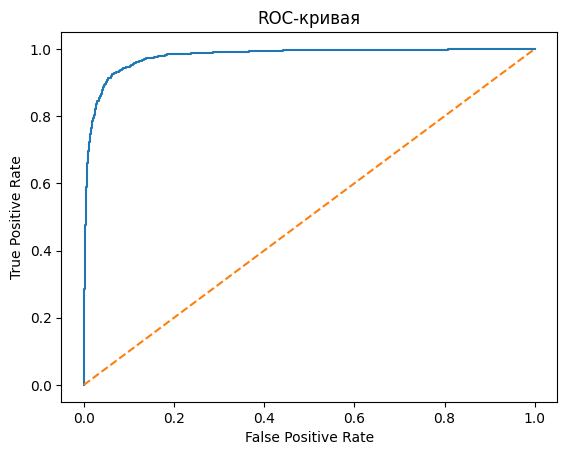

In [16]:
auc_roc_lr, fpr, tpr, thresholds = f1_auc_roc(lgbm, features_valid, target_valid)

#### Результаты на тестовой выборке

Проверим модель на тесте, для этого обучим пайплайн на объединенной тренировочной и валидационной выборках.

In [17]:
lgbm.fit(
    pd.concat(
        [features_train, features_valid]),
    pd.concat(
        [target_train, target_valid])
)

[LightGBM] [Info] Number of positive: 3426, number of negative: 52253
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1663
[LightGBM] [Info] Number of data points in the train set: 55679, number of used features: 123
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['dttm', 'duration', 'pop',
                                                   'blues', 'rap', 'folk',
                                                   'rock', 'soundtrack',
                                                   'instrumental',
                                                   'electronics', 'other',
                                                   'unix', '0', '1', '2', '3',
                                                   '4', '5', '6', '7', '8', '9',
                                                   '10', '11', '12', '13', '14',
                                                   '15', '16', '17', ...]),
                                                 ('mestimateencoder',
                                                  MEstimateEncoder(),
                                                  ['language', 'country',
                                                   'organization'])])),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced',
                                learning_rate=0.20000000000000004,
                                num_leaves=80, random_state=42))])

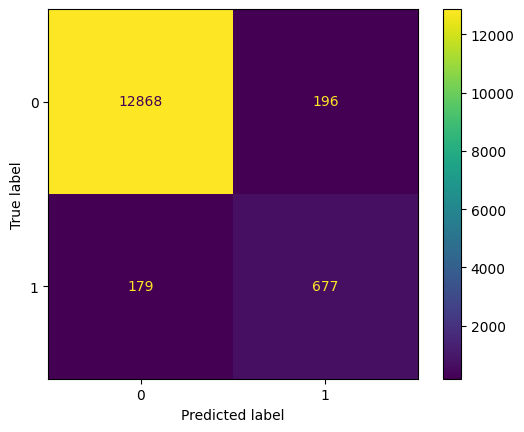

In [18]:
# вывод confusion matrix
# 1 - оригинал, 0 - кавер
proba = lgbm.predict_proba(features_test)
proba_one = proba[:, 1]
predicted = proba_one > 0.68
ConfusionMatrixDisplay(confusion_matrix(target_test, predicted)).plot();

In [19]:
print(f'ROC AUC: {round(roc_auc_score(target_test, predicted), 3)}',
      f'F1: {round(f1_score(target_test, predicted), 3)}',
      f'Precision: {round(precision_score(target_test, predicted), 3)}',
      f'Recall: {round(recall_score(target_test, predicted), 3)}',
      sep='\n')

ROC AUC: 0.888
F1: 0.783
Precision: 0.775
Recall: 0.791


#### Важность признаков

Выведем важность признаков и построим график.

In [20]:
# табличка с важностью от бустинга
temp = pd.DataFrame(
    index=features_train.columns,
    data=lgbm[1].feature_importances_)
temp.columns=['Важность']
idx = temp.apply(
    lambda x: abs(x)).sort_values(
    by=['Важность']).iloc[-20:].index
temp = temp.loc[idx]
temp

,Важность
9,87
6,92
7,97
8,98
1,99
2,102
duration,110
3,111
5,114
instrumental,122


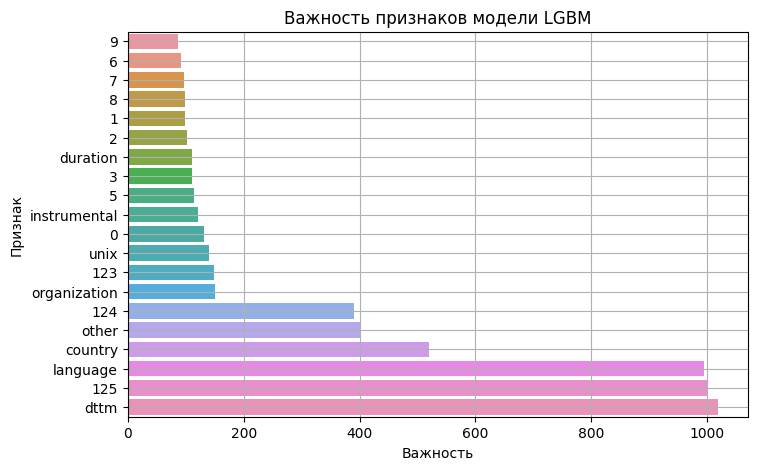

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))
temp.sort_values(by='Важность', inplace=True)
sns.barplot(x=temp['Важность'], y=temp.index)
ax.set_xlabel('Важность')
ax.set_ylabel('Признак')
ax.set_title('Важность признаков модели LGBM')
ax.grid();

**Промежуточный вывод:** модель градиентного бустинга с гиперпараметрами learning_rate = 0.2, num_leaves = 80 и порогом бинаризации 0.68 достаточно хорошо отличает каверы песен от оригиналов. Наиболее важными признаками оказались `dttm`, `language`, `country` и, как ни странно, символ кавычек.

### Подбор группы треков

Построим рекомендательную модель на основе модели ближайших соседей. Вводимый трек вводится в формате таблицы meta_df и преобразуется в вектор внутри модели, затем NearestNeighbor подбирает 100 ближайших соседей этого трека по косинусному расстоянию. Полученные таким образом соседи сортируются по расстоянию и суммированному времени (время добавления трека в сервис + год из кода ISRC). Модель отбирает всех соседей с расстоянием равным нулю (полное совпадение), и добавляет еще три трека (частичное совпадение). Пользователю предоставляется список треков, где первое место занимает потенциальный оригинал песни, а остальные являются каверами, либо похожими треками. Эволюция треков по времени показана столбце `track_evolution`, где исходный трек помечен как "заданный трек". Данный подход хорош тем, что не требует большого количества ресурсов и дополнительных данных. По сути, достаточно названия трека, времени его добавления в сервис и код ISRC.

In [54]:
class Recommender:
    '''
    Рекомендательная модель на основе KNN
    '''
    def __init__(self, database, output):
        '''
        На старте модель получает таблицу database(full_df) с векторизованными именами треков и
        таблицу output(meta_df), рекомендованные песни из которой будут выводиться по track_id.
        Модель изначально настроена на поиск 100 соседей по косинусному сходству.
        '''
        self.database = database.copy()
        self.output = output.copy()
        self.trans_database = database.iloc[:, 19:].copy()
        self.model = NearestNeighbors(
            n_neighbors=100,
            algorithm='brute',
            metric='cosine',
            n_jobs=-1)
        
    def _prepare_data(self, vector):
        '''
        Подготовка входных данных. Сохраняем track_id заданного трека и векторизуем его название.
        '''
        self.id = vector['track_id']
        var = zero_feat.iloc[0].copy()
        counts = Counter(vector['title'].lower())
        for i in counts.keys():
            if i in var:
                var.loc[i] = counts[i]
        return np.append(len(vector['title']), var)
    
    def _cut(self, temp_df):
        '''
        Из полученных сотни соседей забираем только те, у которых расстояние 0 (полные аналоги)
        и следующие три трека, которые с некоторой вероятностью могут быть каверами с измененным
        названием.
        '''
        return pd.concat(
            [temp_df.query('distance == 0'),
             temp_df.query('distance != 0').iloc[:3]]
        )
    
    def _add_evo(self, temp_df):
        '''
        Добавление столбца с эволюцией признаков и создание цепочки треков. Принимается, что
        самый первый трек с наименьшим таймингом будет оригиналом, остальные являются каверами.
        '''
        temp_df.insert(0, 'track_evolution', range(1,len(temp_df)+1))
        temp_df.loc[temp_df['track_id'] == self.id, 'track_evolution'] = 'Заданный трек'
        return temp_df
    
    def find_tracks(self, vector):
        '''
        Входные данные векторизуются, модель выдаёт 100 соседей для введенного вектора.
        Найденные треки сортируются по расстоянию и суммарному времени (время добавления в сервис +
        время регистрации трека в isrc). Из найденных отсортированных треков забираем track_id и 
        в этом же порядке выводим данные из таблицы output по ключу track_id
        '''
        vector = self._prepare_data(vector)
        self.model.fit(self.trans_database)
        dist, idx = self.model.kneighbors(np.array(vector).reshape(1, -1))
        idx = idx.tolist()
        
        temp_df = self.database.iloc[*idx].copy()
        temp_df['distance'], temp_df['time'] = 0, 0
        temp_df['distance'] = dist.tolist()[0]
        temp_df['time'] = temp_df['dttm'] + temp_df['unix']
        temp_df.sort_values(by=['distance', 'time'], inplace=True)
        temp_df = self._cut(temp_df)
        
        id_list = list(temp_df['track_id'].unique())
        df = pd.DataFrame()
        for i in id_list:
            df = pd.concat([df, self.output.query('track_id == @i')])
        df = self._add_evo(df)
        return df

In [55]:
# треки для проверки модели
meta_df.head(10)

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,1.637762e+12,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0
5,551331ee1444de6658e71933eb7f57a2,1.637768e+12,La Ultima Vez,None,QZNJZ2166034,"[FOLK, LATINFOLK]",173000.0
6,2be8bb01bb1aeef0908524dc11935a88,1.637768e+12,Homenaje a Pastor de los Santos,None,QZNJZ2122553,"[FOLK, LATINFOLK]",192100.0
7,3883d1add3ff8b60e77548a64df7c892,1.637768e+12,Los Marginales,None,QZNJZ2122554,"[FOLK, LATINFOLK]",311500.0
8,59aa886979699aa7e4e2a8aed43bfe03,1.637768e+12,Cuenta Conmigo,None,QZNJZ2122555,"[FOLK, LATINFOLK]",250000.0
9,2a38992b7769963937246288ad89b44c,1.637768e+12,Ahora Juego Yo,None,QZNJZ2122556,"[FOLK, LATINFOLK]",156000.0


In [56]:
# выведем связанные треки для первой песни из meta_df
example = Recommender(full_df, meta_df)
example.find_tracks(meta_df.iloc[0])

,track_evolution,track_id,dttm,title,language,isrc,genres,duration
44499,1,804589c2558377b846122344fdc54a72,1.262812e+12,Happy New Year,EN,SEAYD8001060,[POP],263690.0
42981,2,1d50d0a86927e80a48088aae2ff7a6b2,1.418052e+12,Happy New Year,None,None,[JAZZ],250170.0
0,Заданный трек,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,Happy New Year,EN,RUB422103970,[DANCE],161120.0
15290,4,d04c498c13d1a6d0ad4b982d8430d2cf,1.670533e+12,Happy New Year,EN,RUB422203090,[DANCE],212420.0
15439,5,741d050729a9c7d9031935c9e2288538,1.672348e+12,Happy New Year,EN,QMFME2248541,[DANCE],151870.0
46109,6,3b55bf9b7e172b0a3de22675c142c1af,1.307958e+12,Felicidad (Happy new year),None,ES64A1007710,[POP],265038.0
1463,7,17916d7ac62792f32ac2c06e4659ea06,1.639353e+12,In The Pary,None,QZTPX2175467,"[FOREIGNRAP, RAP]",211730.0
53798,8,a06395894baccf7057449195e618938c,1.593712e+12,If you Are Happy,EN,QZ22B2021823,[ALTERNATIVE],177880.0


In [57]:
# проверка всех треков с названием Happy New Year
check = meta_df.query('~title.isna()').copy()
check['title'] = check['title'].str.lower()
check[check['title'].str.contains("happy new year")]

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,1.639688e+12,happy new year,EN,RUB422103970,[DANCE],161120.0
15290,d04c498c13d1a6d0ad4b982d8430d2cf,1.670533e+12,happy new year,EN,RUB422203090,[DANCE],212420.0
15439,741d050729a9c7d9031935c9e2288538,1.672348e+12,happy new year,EN,QMFME2248541,[DANCE],151870.0
42981,1d50d0a86927e80a48088aae2ff7a6b2,1.418052e+12,happy new year,None,None,[JAZZ],250170.0
44499,804589c2558377b846122344fdc54a72,1.262812e+12,happy new year,EN,SEAYD8001060,[POP],263690.0
46109,3b55bf9b7e172b0a3de22675c142c1af,1.307958e+12,felicidad (happy new year),None,ES64A1007710,[POP],265038.0


**Промежуточный вывод:** модель уверенно находит треки с похожим названием, сортирует их по времени. Вывести метрику качества затруднительно по причине сильной зашумленности данных и отсутствия многих оригиналов для каверов, а также нечеткого определения кавера как такового.

## Выводы

**Ход работы**

В рамках данной работы были выполнены следующие этапы:
- проведены исследование и предобработка данных;
- сгенерированы новые признаки: жанры, ISRC-признаки;
- заполнены пропуски в признаках `duration`, `ISRC`, `language`;
- выполнена проверка на дубликаты;
- векторизованы названия треков;
- обучены модели логистической регрессии и градиентного бустинга (random_state для всех моделей был определен как 42);
- по результатам кросс-валидации в качестве основной выбрана модель градиентного бустинга с параметрами learning_rate = 0.2, num_leaves = 80, порог бинаризации выбран как 0.68;
- построена рекомендательная модель, которая выводит цепочку связанных треков.

**Результаты**

В задаче классификации модель градиентного бустинга продемонстрировала следующие результаты на тестовой выборке:
- ROC AUC: 0.888
- F1: 0.783
- Precision: 0.775
- Recall: 0.791

В задаче поиска треков была построена рекомендательная модель на базе NearestNeighbor, которая не требует больших машинных ресурсов, а также использует минимум дополнительной информации.

Для решения бизнес-задачи предполагается использование модели градиентного бустинга для определения метки трек/кавер, затем запуск рекомендательной модели для поиска связанных треков.

**Рекомендации по улучшению решения**

Для улучшения метрик качества в задаче классификации и более точного предсказания кавер/оригинал можно добавить тексты песен в качестве признаков, однако это может замедлить работу моделей и потребует определенного количества машинных ресурсов. Помимо того, не для всех песен может быть добавлен текст. В данной работе было принято допущение, что тексты песен недоступны. Также возможным вектором развития рекомендательной модели является поиск ближайших треков по векторизованной аудидорожке. Каверы песен часто имеют совершенно другой жанр, но при этом сохраняют характерные черты оригинала, которые можно выделить в качестве признаков – это может помочь при поиске похожих треков.